In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
import graphviz
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random
from pprint import pprint
from typing import (Callable, Dict, Iterable, Generic, Sequence, Tuple,
                    Mapping, TypeVar, Set)

from rl.distribution import (Categorical, Distribution,
                            Gaussian, Choose, Constant)
from rl.markov_process import MarkovProcess, NonTerminal, State

## State

State Space: 100 locations on a 10x10 game board with these exceptions:

Transition Probabilities: Equal probability of moving {1,2,3,4,5,6} steps ahead, with exceptions for certain states with a ladder or snake. 

In [6]:
@dataclass(frozen=True)
class Die(Distribution[int]):
    sides: int
    def sample(self) -> int:
        return random.randint(1, self.sides)
    
    def expectation(self) -> int:
        return (int + 1) / 2

@dataclass(frozen=True)
class StateSaL:
    position: int
    
@dataclass
class SnakesandLadders(MarkovProcess[StateSaL]):
    # Create a distribution (a 6-sided die)
    six_sided = Die(6)
    snake = Choose([-10,-7,-5,-3])
    ladder = Choose([2,3,5,7])
    
    
    def transition(self, state: NonTerminal[StateSaL]) -> Categorical[State[StateSaL]]:
        die_roll = self.six_sided.sample()
        snake_s = self.snake.sample()
        ladder_s = self.ladder.sample()
        
        return Categorical({
            NonTerminal(StateSaL(state.state.position + die_roll)): 0.60,
            NonTerminal(StateSaL(state.state.position + die_roll + snake_s)): 0.20,
            NonTerminal(StateSaL(state.state.position + die_roll + ladder_s)): 0.20,
        })

## Test

In [7]:
def run_game(
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    mp = SnakesandLadders()
    start_state_distribution = Constant(
        NonTerminal(StateSaL(position=0))
    )
    return np.vstack([
        np.fromiter((s.state.position for s in itertools.islice(
            mp.simulate(start_state_distribution),
            time_steps + 1
        )), float) for _ in range(num_traces)])

In [8]:
game_traces: np.ndarray = run_game(
        time_steps=20,
        num_traces=10
    )

Text(0.5, 1.0, 'Location on Board')

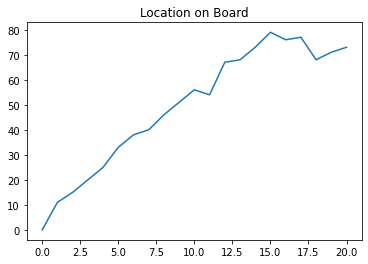

In [9]:
trace1 = game_traces[0]

plt.plot(trace1)
plt.title("Location on Board")

## Finite Markov Process

In [ ]:
class FiniteMarkovProcess(MarkovProcess[S]):
    '''A Markov Process with a finite state space.

    Having a finite state space lets us use tabular methods to work
    with the process (ie dynamic programming).

    '''

    non_terminal_states: Sequence[NonTerminal[S]]
    transition_map: Transition[S]

    def __init__(self, transition_map: Mapping[S, FiniteDistribution[S]]):
        non_terminals: Set[S] = set(transition_map.keys())
        self.transition_map = {
            NonTerminal(s): Categorical(
                {(NonTerminal(s1) if s1 in non_terminals else Terminal(s1)): p
                 for s1, p in v.table().items()}
            ) for s, v in transition_map.items()
        }
        self.non_terminal_states = list(self.transition_map.keys())

    def __repr__(self) -> str:
        display = ""

        for s, d in self.transition_map.items():
            display += f"From State {s.state}:\n"
            for s1, p in d:
                opt = "Terminal " if isinstance(s1, Terminal) else ""
                display += f"  To {opt}State {s1.state} with Probability {p:.3f}\n"

        return display

    def get_transition_matrix(self) -> np.ndarray:
        sz = len(self.non_terminal_states)
        mat = np.zeros((sz, sz))

        for i, s1 in enumerate(self.non_terminal_states):
            for j, s2 in enumerate(self.non_terminal_states):
                mat[i, j] = self.transition(s1).probability(s2)

        return mat

    def transition(self, state: NonTerminal[S])\
            -> FiniteDistribution[State[S]]:
        return self.transition_map[state]

    def get_stationary_distribution(self) -> FiniteDistribution[S]:
        eig_vals, eig_vecs = np.linalg.eig(self.get_transition_matrix().T)
        index_of_first_unit_eig_val = np.where(
            np.abs(eig_vals - 1) < 1e-8)[0][0]
        eig_vec_of_unit_eig_val = np.real(
            eig_vecs[:, index_of_first_unit_eig_val])
        return Categorical({
            self.non_terminal_states[i].state: ev
            for i, ev in enumerate(eig_vec_of_unit_eig_val /
                                   sum(eig_vec_of_unit_eig_val))
        })

    def display_stationary_distribution(self):
        pprint({
            s: round(p, 3)
            for s, p in self.get_stationary_distribution()
        })

    def generate_image(self) -> graphviz.Digraph:
        d = graphviz.Digraph()

        for s in self.transition_map.keys():
            d.node(str(s))

        for s, v in self.transition_map.items():
            for s1, p in v:
                d.edge(str(s), str(s1), label=str(p))

        return d


# Reward processes
@dataclass(frozen=True)
class TransitionStep(Generic[S]):
    state: NonTerminal[S]
    next_state: State[S]
    reward: float

    def add_return(self, γ: float, return_: float) -> ReturnStep[S]:
        '''Given a γ and the return from 'next_state', this annotates the
        transition with a return for 'state'.

        '''
        return ReturnStep(
            self.state,
            self.next_state,
            self.reward,
            return_=self.reward + γ * return_
        )


@dataclass(frozen=True)
class ReturnStep(TransitionStep[S]):
    return_: float